<a href="https://colab.research.google.com/github/101Vaibhav04/Portfolio-Optimization/blob/main/CFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the Excel file
file_path = '/content/JSWSTEEL_ohlc (1).xlsx'
data = pd.read_excel(file_path)

# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)
# Resample the data by weeks, ending on Friday ('W-FRI')
weekly_data = data.resample('W-FRI').last()



# Calculate the percentage weekly returns
weekly_returns = weekly_data.pct_change().dropna()

# Verify the weekly returns
print(weekly_returns.head())


            JSWSTEEL  TATASTEEL    MARUTI       SBI  TATAMOTORS     TRENT  \
Date                                                                        
2019-10-04 -0.075549  -0.113506 -0.018321 -0.111131   -0.002085 -0.015669   
2019-10-11  0.012113   0.017712  0.007414  0.018404    0.013790  0.035918   
2019-10-18  0.028078   0.060767  0.090074  0.059320    0.128194  0.023936   
2019-10-25 -0.026864   0.007369  0.023123  0.044131   -0.073073  0.046657   
2019-11-01  0.093168   0.102830  0.019743  0.113657    0.379976  0.006342   

               TITAN      ONGC  RELIANCE       M&M  ...  PIDILITIND   SIEMENS  \
Date                                                ...                         
2019-10-04 -0.025817 -0.014829 -0.000726  0.011472  ...   -0.073774  0.016136   
2019-10-11 -0.005836 -0.004245  0.034019 -0.002431  ...   -0.001426  0.026640   
2019-10-18  0.045835  0.112403  0.047131  0.053240  ...   -0.010542  0.047292   
2019-10-25  0.026449 -0.027526  0.010485 -0.022875  ...

In [ ]:
# Set the span for the exponential weighting
span = 60  # You can adjust the span based on your preference

# Calculate the exponentially weighted covariance matrix using weekly returns
ew_cov_matrix = weekly_returns.ewm(span=span).cov(pairwise=True).iloc[-len(weekly_returns.columns):, :]


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate portfolio variance given a set of weights and covariance matrix
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Constraints: the sum of portfolio weights must be equal to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Bounds for each weight (between 0 and 1 for long-only portfolio)
num_assets = len(weekly_returns.columns)
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess for portfolio weights (equally weighted)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# Extract the most recent covariance matrix (last period's matrix)
latest_cov_matrix = ew_cov_matrix.iloc[-num_assets:, -num_assets:].values

# Use 'SLSQP' method to optimize the weights to minimize portfolio variance
result = minimize(portfolio_variance, initial_weights, args=(latest_cov_matrix,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights = result.x

# Display the optimal weights
print("Optimal Weights: ", optimal_weights)


Optimal Weights:  [6.74864472e-03 0.00000000e+00 2.99823241e-02 1.80588116e-02
 0.00000000e+00 2.18992784e-02 1.64399709e-02 2.89429814e-02
 2.22612363e-02 0.00000000e+00 4.96324110e-02 4.10056803e-02
 4.41984496e-02 4.23832556e-02 1.87781040e-02 1.34223380e-02
 2.19834256e-02 2.27448406e-02 7.24147839e-05 4.74413788e-02
 2.15752798e-02 2.18762010e-04 2.69884184e-02 4.05428798e-04
 3.90460692e-03 1.99513015e-04 4.08105644e-02 2.33940070e-02
 5.00694722e-03 0.00000000e+00 2.79369735e-02 2.47849824e-02
 1.06337326e-03 2.48722364e-02 5.36186905e-02 3.79470760e-18
 4.57310741e-02 9.30940888e-04 1.23510206e-02 2.24089054e-02
 5.24809679e-02 4.21501932e-02 1.06545017e-02 3.63245036e-02
 0.00000000e+00 0.00000000e+00 2.37144232e-04 0.00000000e+00
 2.50327549e-02 3.37870970e-02 1.71355672e-02]


In [ ]:
# Set window size for covariance estimation (e.g., 100 weekly returns)
window_size = 100

# Initialize variables for the rolling window
portfolios = []
dates = weekly_returns.index[window_size:]  # Dates after the first window

# Loop over each period and compute optimal weights
for i in range(len(dates)):
    # Select the rolling window of weekly returns
    rolling_window_returns = weekly_returns.iloc[i:i + window_size]

    # Compute the exponentially weighted covariance matrix for this window
    rolling_cov_matrix = rolling_window_returns.ewm(span=span).cov(pairwise=True).iloc[-num_assets:, -num_assets:].values

    # Optimize the portfolio for this period
    result = minimize(portfolio_variance, initial_weights, args=(rolling_cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    # Store the optimal weights for this period
    portfolios.append(result.x)

# After the loop, `portfolios` will contain the optimal weights for each rebalancing period


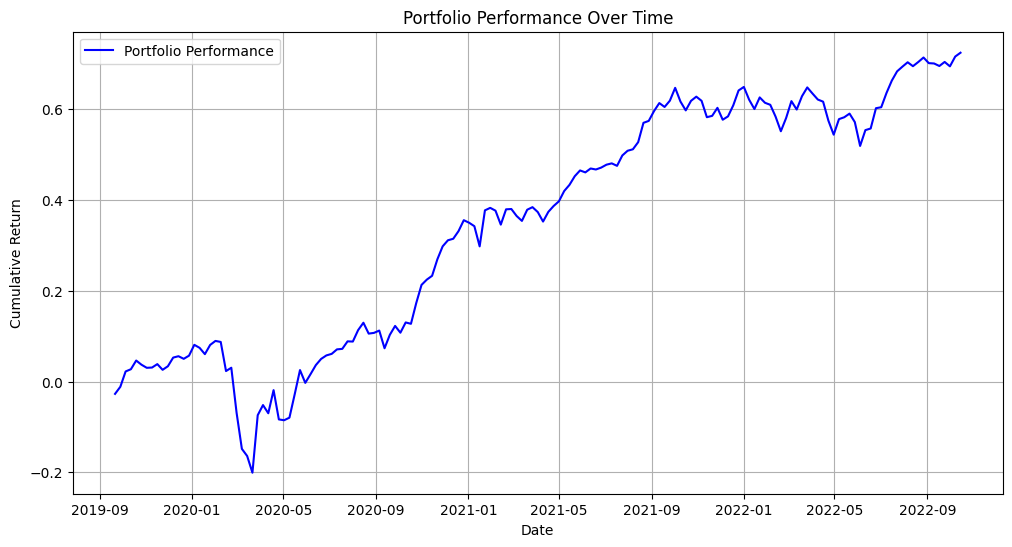

In [ ]:
# Calculate portfolio returns using the optimal weights
portfolio_values = []
for i in range(len(portfolios)):
    # Portfolio returns = sum of weights * asset returns for the next week
    portfolio_return = np.dot(optimal_weights, weekly_returns.iloc[i])  # Change portfolios[i] to optimal_weights
    portfolio_values.append(portfolio_return)

# Convert portfolio returns into a cumulative performance curve
portfolio_performance = pd.Series(portfolio_values).cumsum()

# Ensure the index is in datetime format for plotting
# Convert the index to a Timestamp to avoid the TypeError
dates = trading_week_data.index.to_timestamp()  # Convert PeriodIndex to Timestamp

# Plot the portfolio performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dates[:len(portfolio_performance)], portfolio_performance, label='Portfolio Performance', color='blue')
plt.title('Portfolio Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


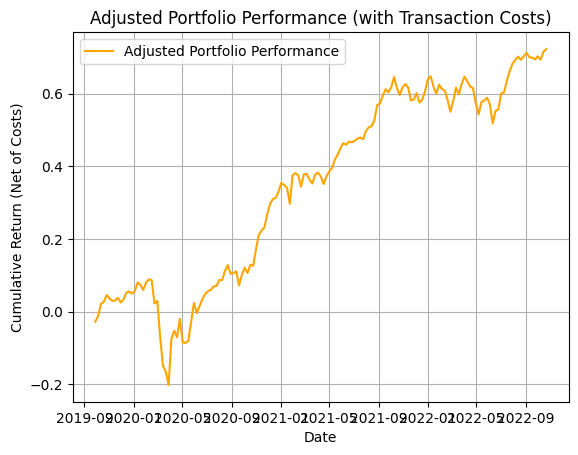

In [ ]:
# Define the transaction cost rate
transaction_cost_rate = 0.001

# Calculate the transaction costs by comparing weights week to week
transaction_costs = []
for i in range(1, len(optimal_weights)):  # Use optimal_weights instead of portfolios
    # The change in weights from previous to current week
    weight_change = np.abs(optimal_weights[i] - optimal_weights[i - 1])

    # Calculate transaction cost
    cost = transaction_cost_rate * np.sum(weight_change)
    transaction_costs.append(cost)

# Ensure transaction_costs is aligned with the portfolio_performance
# Pad the beginning of transaction_costs with zero to match lengths
transaction_costs = [0] + transaction_costs  # Add a zero for the initial week

# If portfolio_performance is calculated on weekly returns, align its length with transaction_costs
# Pad portfolio_performance to ensure they match (optional: or slice if needed)
if len(transaction_costs) < len(portfolio_performance):
    transaction_costs += [0] * (len(portfolio_performance) - len(transaction_costs))  # Extend with zeros
elif len(transaction_costs) > len(portfolio_performance):
    transaction_costs = transaction_costs[:len(portfolio_performance)]  # Trim if too long

# Adjust the portfolio performance by deducting cumulative transaction costs
adjusted_portfolio_performance = portfolio_performance[:len(transaction_costs)] - np.cumsum(transaction_costs)

# Plot the adjusted portfolio performance
plt.plot(dates[1:len(adjusted_portfolio_performance)+1], adjusted_portfolio_performance, label='Adjusted Portfolio Performance', color='orange')
plt.title('Adjusted Portfolio Performance (with Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Net of Costs)')
plt.legend()
plt.grid()
plt.show()
